In [1]:
import SetGenerator

In [2]:
import pandas as pd
import PeriodicGraph
import Task
import TaskSet


def get_execution_transition(ss):
    ss.loc[ss["t_id"] == ss["sched_id"], "rct"] -= 1
    ss.loc[ss["X"] >= ss["crit"], "at"] -= 1
    return ss


def get_done_scope(ss):
    scope = ss["rct"] == 0
    scope &= ss["X"] == ss["crit"]
    return scope


def get_c_at_k(ss, k):
    return [ss.at[x] for x in list(zip(ss.index, k))]


def get_termination_transition(ss, signal=False):
    terminate_scope = get_done_scope(ss)

    if signal:
        terminate_scope |= ss["t_id"] == ss["sched_id"]

    new_rct = get_c_at_k(
        ss.loc[terminate_scope], ss.loc[terminate_scope, "crit"]
    )

    ss.loc[terminate_scope, "rct"] = new_rct
    ss.loc[terminate_scope, "at"] += ss.loc[terminate_scope, "T"]
    return ss


def get_termination_transitions(ss):
    ss_done_0 = get_termination_transition(ss.copy(), signal=False)
    ss_done_1 = get_termination_transition(ss.copy(), signal=True)
    max_id = ss_done_0["ss_id"].max()
    n_tasks = ss_done_0["t_id"].max() + 1
    ss_done_1["ss_id"] = [
        i
        for i in range(
            max_id + 1, max_id + 1 + int(ss_done_1.shape[0] / n_tasks)
        )
        for _ in range(n_tasks)
    ]
    # range(max_id+1,max_id+1+ss_done_1.shape[0])
    ss_done = pd.concat([ss_done_0, ss_done_1], ignore_index=True)
    return ss_done


def get_active_scope(ss):
    scope = ss["at"] < 0
    scope |= (ss["at"] == 0) & (ss["rct"] > 0)
    return scope


def get_crit(ss):
    scope = get_active_scope(ss)
    scope &= ss["rct"] == 0
    ss_scope = ss["ss_id"].isin(ss.loc[scope, "ss_id"].unique())
    new_crit = ss["crit"].copy()
    new_crit.loc[ss_scope] += 1
    return new_crit


def get_critical_transition(ss):
    new_crit = get_crit(ss)

    still_active = (ss["X"] >= new_crit) & (new_crit != ss["crit"])

    if still_active.any():

        current_rct = get_c_at_k(
            ss.loc[still_active], ss.loc[still_active, "crit"]
        )
        next_rct = get_c_at_k(ss.loc[still_active], new_crit.loc[still_active])

        ss.loc[still_active, "rct"] += next_rct
        ss.loc[still_active, "rct"] -= current_rct

    not_active = ss["X"] < new_crit
    ss.loc[not_active, "rct"] = 0
    ss.loc[not_active, "at"] = 0
    ss.loc[:, "crit"] = new_crit

    return ss


def unstack_ss(df):
    df = df.drop("ss_id", axis=1)
    df = df.set_index("t_id")
    df = df.unstack()
    return df


def widen_ss(ss):
    ss_core = ss[["ss_id", "t_id", "at", "rct", "crit"]]
    grouped = ss_core.groupby("ss_id")
    ss_wide = grouped.apply(unstack_ss)
    return ss_wide


def remove_duplicates(ss):
    ss_join = widen_ss(ss)
    duplicated_scope = ss_join.duplicated()
    duplicated_ssid = ss_join.loc[duplicated_scope].index
    return ss.loc[~ss["ss_id"].isin(duplicated_ssid)]


def get_worst_laxity(ss):
    return (
        ss["at"]
        - (ss["rct"] + ss[1] - ss.apply(lambda row: row[1], axis=1))
        + ss["D"]
    )


def LWLF(ss):

    ss["wl"] = get_worst_laxity(ss)

    active_scope = get_active_scope(ss)

    sched_loc = ss.loc[active_scope].groupby("ss_id")["wl"].idxmin()
    sched_ids = ss.loc[sched_loc, ["ss_id", "t_id"]].rename(
        columns={"t_id": "sched_id"}
    )
    ss = ss.drop("sched_id", axis=1).merge(sched_ids, on="ss_id", how="left")

    ss["sched_id"] = ss["sched_id"].fillna(-1)

    return ss


def check(ss):
    scope = ss[0] <= ss[1]
    assert scope.all(), f"\n{ss.loc[~scope]}"
    
    scope = ss["crit"] <= 1
    assert scope.all(), f"\n{ss.loc[~scope]}"

    scope = ((ss["X"] < ss["crit"]) & (ss["rct"] == 0) & (ss["at"] == 0)) | (
        ss["X"] >= ss["crit"]
    )
    assert scope.all(), f"\n{ss.loc[~scope]}"

    scope = ss["crit"] >= 0
    assert scope.all(), f"\n{ss.loc[~scope]}"

    scope = ss["at"] <= ss["T"]
    assert scope.all(), f"\n{ss.loc[~scope]}"

    scope = ss["rct"] >= 0
    assert scope.all(), f"\n{ss.loc[~scope]}"

    scope = ss["rct"] <= ss[1]
    assert scope.all(), f"\n{ss.loc[~scope]}"


def get_laxity(ss):
    return ss["at"] - ss["rct"] + ss["D"]


def fail(ss):
    ss["l"] = get_laxity(ss)
    return (ss["l"] < 0).any()


def hash_ss(df):
    return hash(df.droplevel(0).reset_index().values.data.tobytes())


def get_neighbours(ss):
    ss = LWLF(ss)
    ss = get_execution_transition(ss)
    ss = get_termination_transitions(ss)
    ss = get_critical_transition(ss)
    ss = remove_duplicates(ss)
    check(ss)
    return ss

In [16]:
def bfs(ss):
    visited = set()
    ss_hashes = ss.set_index(["ss_id", "t_id"])[["at","rct","crit"]].groupby(level="ss_id").apply(hash_ss)
    i = 0

    while ss.shape[0] > 0:
        visited.update(ss_hashes)

        ss_old = ss.copy()
        ss = get_neighbours(ss)

        if fail(ss):
            return False, len(visited)
            break

        ss_hashes = ss.set_index(["ss_id", "t_id"])[["at","rct","crit"]].groupby(level="ss_id").apply(hash_ss)

        ss_visited = ss_hashes.isin(visited)
        ss_visited.name = "visited"

        ss = ss.merge(ss_visited, left_on="ss_id", right_index=True)
        ss = ss.loc[~ss["visited"]]
        ss = ss.drop("visited", axis=1)
        
        i+= 1
    return True, len(visited)

In [4]:
def ts_to_ss(ts):
    pg = PeriodicGraph.PeriodicGraph(ts)
    ss = pg.getInitialVertex()
    df = ss.ss
    df["crit"] = ss.crit
    ss = df.join(ts.tasks)
    ss["t_id"] = ss.index
    ss["ss_id"] = 0
    ss["sched_id"]=-1
    ss["wl"] = get_worst_laxity(ss)
    return ss

In [5]:
def bfs_ts(ts):
    ss = ts_to_ss(ts)
    u = ts.getAverageUtilisation()
    res, n = bfs(ss)
    occurence = pd.Series([u, res, n], ["u", "res", "n"])
    return occurence

In [6]:
def bfs_t(t, x, c0, c1):
    task = Task.Task(O=0, T=t, D=t, X=x, C=(c0, c1))
    task_set = TaskSet.TaskSet([task])
    return bfs_ts(task_set)

In [7]:
import multiprocessing as mp                                                                                     
mp.set_start_method("fork") 

In [8]:
import time
import concurrent.futures
from tqdm import tqdm
import pandas as pd

In [11]:
def experiment(pHI, rHI, CmaxLO, Tmax, u, nbT):
    sg = SetGenerator.SetGenerator(pHI, rHI, CmaxLO, Tmax, u, nbT)
    ts = sg.generateSetPerformance(2)
    s = time.time()
    occurence = bfs_ts(ts)
    occurence["time"] = time.time()-s
    occurence["nbt"] = nbT
    occurence["u"] = u
    return occurence

In [17]:
pHI = 0.5
rHI = 2
Tmax = 30
CmaxLO = -1
nbT = 2

def f_unpack(arg):
    return experiment(*arg)

experiment_arg = []
with concurrent.futures.ProcessPoolExecutor() as executor:
    for u in range(0, 100, 1):
        for i in range(100):
            experiment_arg.append((pHI, rHI, CmaxLO, Tmax, u/100.0, nbT))
    results = pd.DataFrame(tqdm(executor.map(f_unpack, experiment_arg), total=len(experiment_arg)))

  2%|▊                                 | 234/10000 [02:39<1:35:04,  1.71it/s]/Users/simonpicard/Documents/mcae/Scheduler.py:25: RuntimeWarning: invalid value encountered in double_scalars
  relativity = self.getUtilisation(1, 0) / (
 25%|████████▎                        | 2500/10000 [28:48<1:09:10,  1.81it/s]/Users/simonpicard/Documents/mcae/Scheduler.py:25: RuntimeWarning: invalid value encountered in double_scalars
  relativity = self.getUtilisation(1, 0) / (
 39%|█████████████▌                     | 3878/10000 [44:09<51:28,  1.98it/s]/Users/simonpicard/Documents/mcae/Scheduler.py:25: RuntimeWarning: invalid value encountered in double_scalars
  relativity = self.getUtilisation(1, 0) / (
 41%|██████████████▎                    | 4089/10000 [46:24<48:34,  2.03it/s]/Users/simonpicard/Documents/mcae/Scheduler.py:25: RuntimeWarning: invalid value encountered in double_scalars
  relativity = self.getUtilisation(1, 0) / (
 44%|███████████████▌                   | 4441/10000 [50:24<49:45,  

In [19]:
results.to_csv("lwlf_test1.csv")

In [27]:
results["u"] = (results["u"]*100).apply(round)

In [30]:
results["res"] = results["res"].apply(int)

<AxesSubplot:xlabel='u'>

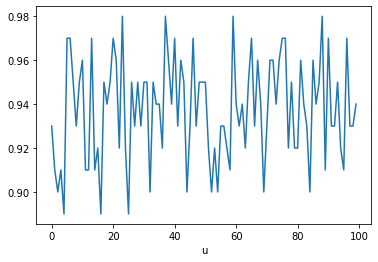

In [32]:
results.groupby("u")["res"].mean().plot()

In [5]:
from importlib import reload

In [10]:
reload(SetGenerator)
pHI = 0.5
rHI = 2
Tmax = 30
CmaxLO = -1
nbT = 2
U = 0.5
sg = SetGenerator.SetGenerator(pHI, rHI, CmaxLO, Tmax, U, nbT)

In [54]:
sg.generateSetPerformance(2)

     O     T     D    X     0     1        U0        U1
0  0.0  20.0  20.0  0.0   2.0   2.0  0.100000  0.100000
1  0.0  27.0  27.0  1.0  24.0  25.0  0.888889  0.925926

In [2]:
list(range(0, 1, 0.05))

TypeError: 'float' object cannot be interpreted as an integer

In [ ]:
import asyncio
import concurrent.futures
from tqdm import tqdm

def f_unpack(arg):
    return bfs_t(*arg)

futures = []

test_iter = []
s = 1
with concurrent.futures.ProcessPoolExecutor() as executor:
    loop = asyncio.get_event_loop()
    for t in range(1, 31, s):
        for c1 in range(1, t+1, s):
            for x in range(2):
                for c0 in [c1] if x==0 else range(1, c1):
                    # print(t, x, c0, c1)
                    test_iter.append([t, x, c0, c1])
                    #futures.append(
                    #    loop.run_in_executor(
                    #        executor,
                    #        bfs_t,
                    #        t, x, c0, c1,
                    #    ))
    #full_list_of_results = []
    #for r in tqdm(await asyncio.gather(*futures)):
    #    full_list_of_results.extend(r)
        
    results = pd.DataFrame(tqdm(executor.map(f_unpack, test_iter), total=len(test_iter)))

 26%|█████████▏                          | 1269/4960 [01:32<06:11,  9.94it/s]

<AxesSubplot:xlabel='T', ylabel='n'>

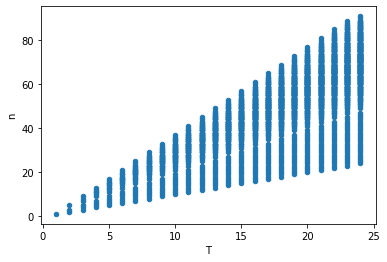

In [1075]:
space.plot("T", "n", kind="scatter")

<AxesSubplot:xlabel='1', ylabel='n'>

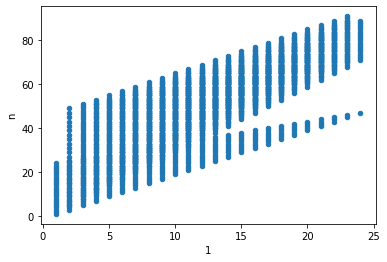

In [1080]:
space.plot(1, "n", kind="scatter")

<AxesSubplot:xlabel='0', ylabel='n'>

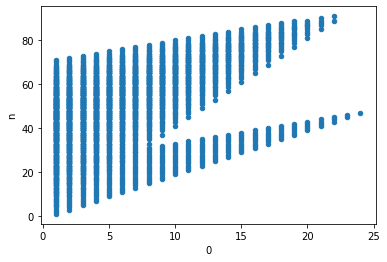

In [1081]:
space.plot(0, "n", kind="scatter")

In [39]:
from importlib import reload
reload(TaskSet)

<module 'TaskSet' from '/Users/simonpicard/Documents/mcae/TaskSet.py'>

In [46]:
def get_initial_state(tasks):
    ss = tasks[["O", 0]].rename(columns={0: "rct", "O": "at"})
    ss["crit"] = 0
    ss = ss.join(tasks)
    ss["t_id"] = ss.index
    ss["ss_id"] = 0
    ss["sched_id"] = -1
    ss["wl"] = get_worst_laxity(ss)
    return ss

In [47]:
task = Task.Task(O=0, T=10, D=10, X=0, C=(3, 3))
task_set = TaskSet.TaskSet([task])

tasks = task_set.get_df()

In [48]:
get_initial_state(tasks)

,at,rct,crit,O,T,D,X,0,1,U0,U1,t_id,ss_id,sched_id,wl
0,0.0,3.0,0,0.0,10.0,10.0,0.0,3.0,3.0,0.3,0.3,0,0,-1,7.0
